In [1]:
using PyPlot, LightGraphs

In [239]:
# a function for BGSM_general (Section 4)

# y : a vector of data
# D : graph incidence matrix
# X : a design matrix
# w : a support vector
# nu : a prior precision for alpha
# v0, v1 : tuning parameters
# a, b : inverse gamma hyperparameters
# convtol : convergence tolerance
# orthotol : tolerance to check whether w is an eigenvector of X'X
# iter : a number of maximum allowed iteration

function BGSM_clust_reg(      y;                                    # a data and a graph
                              X = speye(length(n)),                 # a design matrix
                              v0 = 1e-1, v1 = 1e4,                  # tuning parameters
                              a = 0, b = sum(size(X)),              # inverse gamma hyperparmeters
                              A = length(y), B = 1,                 # beta bernoulli hyperparmeters
                              convtol = 1e-10, orthotol = 1e-10,    # tolerances
                              iter = 1000,                          # a number of maximum allowed iteration
                              verbose = true)                       # verbose option
    
    # check if y is a vector or a matrix
    if length(size(y)) == 1
        # n = length of y
        n = length(y); d = 1;
        println("\"y\" is a vector of length $n");
    else
        n,d = size(y);
        println("\"y\" is a matrix of size $n by $d");
    end

    # check if X has an input
    if size(X) == (0,0)
        X = speye(n);
        error("A design matrix \"X\" has no input: use speye(n) as a default, \"n\" = $n");
    elseif n != size(X,1)
        error("Error : A length of \"y\" must be equal to a number of rows in \"X\".");
    end
    
    p = size(X,2);
    
    # initialze
    theta = (X'*X + 1e-4 * speye(p))\(X'*y);
    mu = copy(theta);
    sigmasq = 1;
    q = ones(p)/p;
    
    # loop start
    for i = 1:iter
        
        # save for convergence check
        q_old = copy(q);
        
        # E-step : update q and tau
        q = 1 ./ (1 + exp.(-2*sum(theta.*mu,2)[:]/(d * sigmasq * v0)));
        tau = Diagonal;
        
        # M-step : update theta, delta, sigma^2
        theta = (X'*X + Diagonal(tau))\(X'*y);
        mu = theta .* (2 * q - 1);
        sigmasq = (sum((y - X*theta).^2) + sum((theta - mu).^2)/v0 + b)/(n+p+a+1)/d;

        # convergence criterion
        err = norm(q - q_old)/length(q);
        
        # convergence check
        if err < convtol
            if verbose == true
                @printf "iteration: %d, error: %0.2e\n" i err;
                println("the algorithm converges at $i-th iteration");
            end
            break;
        end
        
        # printout
        if rem(i,5) == 0 && verbose == true
            @printf "iteration: %d, error: %0.2e\n" i err;
        end
    end
    
    return Dict([
                (:theta, theta), (:mu, mu), (:q, 2*q-1), (:X, X), (:y, y), (:sigmasq, sigmasq)
                ])
end

BGSM_clust_reg (generic function with 1 method)

In [231]:
srand(1);
n = 100; p = 200;
X = randn(n,p); X1 = [zeros(n) X];
w = [1;zeros(p)];
t = [zeros(Int(4*p/5));5.0*ones(Int(p/5))]
y = X*t + randn(n);
g = Graph(p+1);
for i = 1:p
    add_edge!(g,(1,i+1))
end
A = adjacency_matrix(g);
D = full(incidence_matrix(g, oriented = true))';
include("code/BGSM_general.jl")
out = BGSM_general(y, D, v0 = 1e-1*0.8, X = X1, w = w, A = size(D,2), b = sum(size(D)), nu = Inf);

A data "y" has input of length "n" = 100
A graph incidence matrix "D" has input of size ("m" = 200,"p" = 201)
We initialize at "α" = mean(y), "θ" = y-α, "σ^2" = var(y) and "η" = 1/2
iteration: 5, error: 6.37e-03
iteration: 10, error: 5.01e-04
iteration: 15, error: 9.97e-05
iteration: 20, error: 2.43e-03
iteration: 25, error: 8.66e-04
iteration: 30, error: 2.97e-04
iteration: 35, error: 7.98e-04
iteration: 38, error: 6.64e-13
the algorithm converges at 38-th iteration


In [234]:
out = BGSM_clust_reg(y, X = X, v0 = 1e-1 * 5);

"y" is a vector of length 100
iteration: 5, error: 2.93e-03
iteration: 10, error: 2.07e-03
iteration: 15, error: 1.94e-03
iteration: 20, error: 6.49e-04
iteration: 25, error: 4.84e-05
iteration: 30, error: 9.23e-04
iteration: 35, error: 1.34e-03
iteration: 40, error: 1.04e-05
iteration: 45, error: 1.26e-03
iteration: 50, error: 1.13e-08
iteration: 52, error: 1.85e-12
the algorithm converges at 52-th iteration


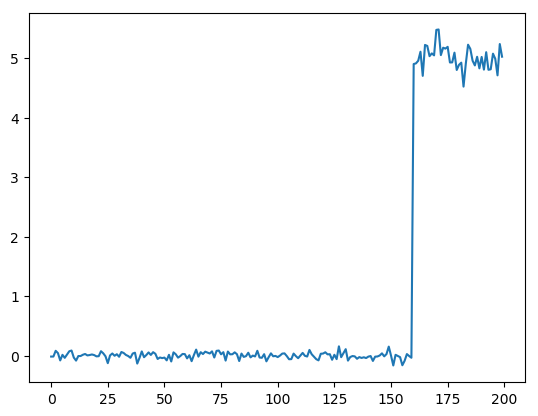

a fitted sigma2 value is 1.000

In [237]:
plot(out[:theta])
@printf "a fitted sigma2 value is %0.3f" out[:sigmasq]

In [240]:
srand(1)
n = 100; p = 200; d = 10;
X = randn(n,p); X1 = [zeros(n) X];
w = [1;zeros(p)];
t = [zeros(Int(4*p/5),d);5.0*ones(Int(p/5),d)]
y = X*t + randn(n,d);
out = BGSM_clust_reg(y, X = X, v0 = 1e0, b = (n+p) * d, B = d);

"y" is a matrix of size 100 by 10
iteration: 5, error: 3.71e-03
iteration: 10, error: 1.46e-03
iteration: 15, error: 1.24e-03
iteration: 19, error: 3.01e-11
the algorithm converges at 19-th iteration


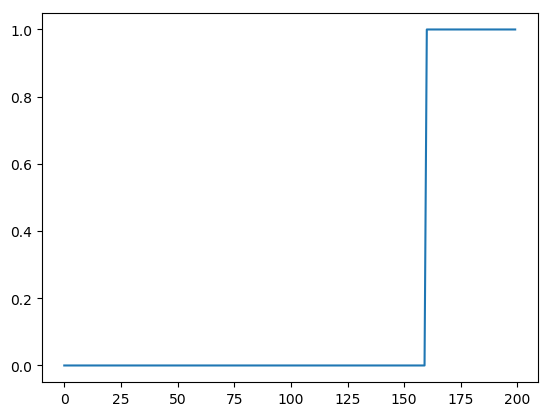

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x142e3f810>

In [241]:
plot(out[:q])

In [333]:
# a function for BSGM_cartesian_biclust (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BSGM_newmodel(y;
                       v0 = 1e-1,
                       convtol = 1e-14,  
                       iter = 100)
                            
    
    # get size
    n1,n2 = size(y); n = n1 * n2;
    
    # initialize
    theta = copy(y);
    mu1 = copy(y); mu2 = copy(y);
    q1 = zeros(n1); q2 = zeros(n2,n2);
    sigmasq1 = 1; sigmasq2 = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = sum(theta .* mu1,2)[:];
        q1 = 1./(1 + exp.(-2*d1/(n2*v0)));
        
        # E-step: update g2
        d2 = reshape(sum((repmat(theta',n2,1) - kron(mu2',ones(n2))).^2,2),n2,n2)';
        q2 = exp.(-d2/(2*n1*v0)); q2 = q2 ./ sum(q2,2);
        
        # M-step: update theta
        L1 = Diagonal(4 .* q1 .*(1-q1))/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        theta = reshape((speye(n) + L/n)\y[:], n1,n2);
        mu1 = (2 * q1 - 1) .* theta;
        mu2 = theta * (q2 ./ sum(q2,1));
        
        if rem(i,5) == 0
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if norm(q1 - q1_old) + norm(q2 - q2_old) < convtol
            @printf "the algorithm converged at %3d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2),
                (:mu1, ((2 * q1 - 1) .* mu1) * q2'), (:mu2, ((2 * q1 - 1) .* mu2) * q2')
                ])
end

BSGM_newmodel (generic function with 1 method)

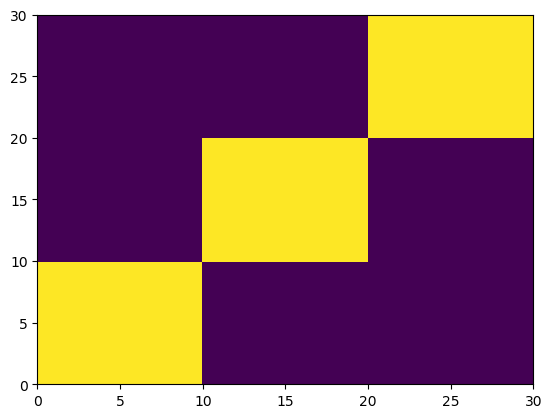

PyObject <matplotlib.collections.QuadMesh object at 0x13ca60cd0>

In [342]:
q2 = out[:q2]
pcolormesh((q2 ./ sum(q2,1)) * q2')

In [340]:
srand(1);
y = [ones(10,10) 2*ones(10,10) 3*ones(10,10); zeros(20,30)] * 10 + randn(30,30)
out = BSGM_newmodel(y, v0 = 1e-1*5)

  5-th iteration done: error = 7.07e-02
 10-th iteration done: error = 1.17e-02
 15-th iteration done: error = 6.43e-03
 20-th iteration done: error = 4.09e-03
 25-th iteration done: error = 2.72e-03
 30-th iteration done: error = 1.84e-03
 35-th iteration done: error = 1.26e-03
 40-th iteration done: error = 8.65e-04
 45-th iteration done: error = 5.94e-04
 50-th iteration done: error = 4.09e-04
 55-th iteration done: error = 2.82e-04
 60-th iteration done: error = 1.94e-04
 65-th iteration done: error = 1.34e-04
 70-th iteration done: error = 9.20e-05
 75-th iteration done: error = 6.33e-05
 80-th iteration done: error = 4.36e-05
 85-th iteration done: error = 3.00e-05
 90-th iteration done: error = 2.07e-05
 95-th iteration done: error = 1.42e-05
100-th iteration done: error = 9.81e-06


Dict{Symbol,Array{Float64,N} where N} with 5 entries:
  :q2    => [0.116436 0.103201 … 1.24823e-58 4.7821e-60; 0.116436 0.103201 … 1.…
  :mu1   => [9.82525 9.82525 … 30.3206 30.3206; 9.66252 9.66252 … 29.9584 29.95…
  :mu2   => [9.74991 9.74991 … 30.2223 30.2223; 9.68494 9.68494 … 29.981 29.981…
  :theta => [10.2961 9.83468 … 30.4786 31.4501; 10.3808 7.88862 … 30.1236 28.79…
  :q1    => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.986027, 0.9…

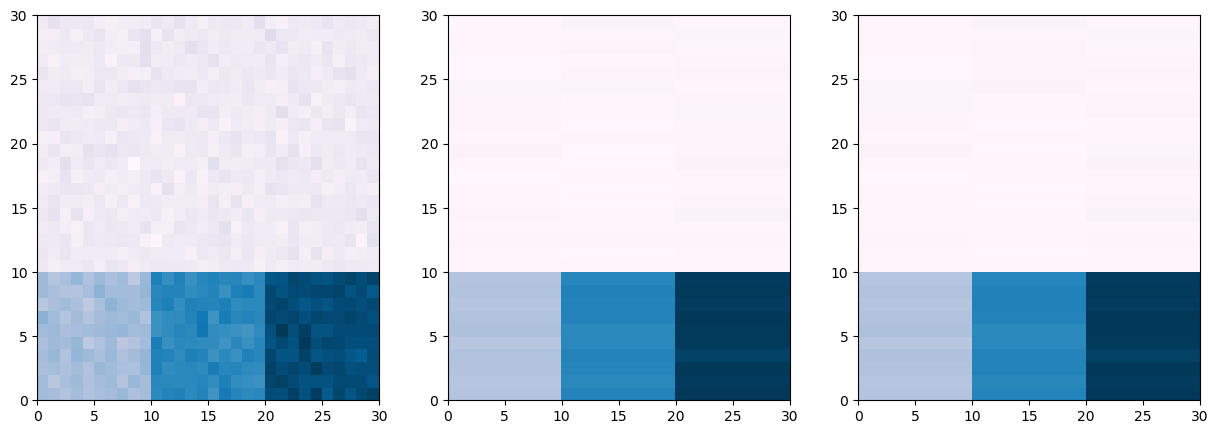

PyObject <matplotlib.collections.QuadMesh object at 0x13fb71790>

In [341]:
fig, ax = subplots(figsize = (15,5))
subplot(131); pcolormesh(out[:theta], cmap = "PuBu")
subplot(132); pcolormesh(out[:mu1], cmap = "PuBu")
subplot(133); pcolormesh(out[:mu2], cmap = "PuBu")

In [298]:
# get size
v0 = 1e2
    n1,n2 = size(y); n = n1 * n2;
    
    
    # initialize
    theta = copy(y);
    mu1 = copy(y); mu2 = copy(y);
    q1 = zeros(n1); q2 = zeros(n2,n2);
    sigmasq1 = 1; sigmasq2 = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = sum(theta .* mu1,2)[:];
        q1 = 1./(1 + exp.(-2*d1/(n2*v0)));
        
        # E-step: update g2
        d2 = reshape(sum((repmat(theta',n2,1) - kron(mu2',ones(n2))).^2,2),n2,n2)';
        q2 = exp.(-d2/(2*n1*v0)); q2 = q2 ./ sum(q2,2);
        
        # M-step: update theta
        L1 = Diagonal(4 .* q1 .*(1-q1))/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        theta = reshape((speye(n) + L)\y[:], n1,n2);
        mu1 = (2 * q1 - 1) .* theta;
        mu2 = theta * (q2 ./ sum(q2,1));
        
        if rem(i,5) == 0
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if norm(q1 - q1_old) + norm(q2 - q2_old) < convtol
            @printf "the algorithm converged at %3d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
end
mu1

  5-th iteration done: error = 1.86e-03
 10-th iteration done: error = 1.08e-06
the algorithm converged at  14-th iteration: error = 2.77e-09


30×30 Array{Float64,2}:
  9.53024   9.23339  10.0076   …  28.7818  29.3813  30.1756  29.4128
  8.69164   9.71715  11.8101      29.4787  30.1364  29.0313  28.0152
 11.2101    9.68845   9.09726     29.5813  30.6122  30.4457  29.0561
 10.215    10.6118    9.59879     28.5626  29.7547  29.8093  29.5393
 10.7258    9.70111   9.6434      30.8554  29.6288  29.9516  30.7503
  8.73786   9.17702   9.64516  …  29.8872  29.6712  29.419   30.553 
  8.48463   8.78837   9.51786     31.6284  30.9559  31.0573  28.2987
  9.72412   9.96176   8.78843     30.1043  30.0317  31.4629  31.8868
  8.69448   9.77187   9.90224     30.7348  30.8797  28.6348  31.2232
  7.8877   11.3793   10.39        30.3304  29.1053  30.5454  31.9181
  0.0       0.0      -0.0      …  -0.0     -0.0      0.0     -0.0   
 -0.0      -0.0       0.0         -0.0     -0.0      0.0     -0.0   
  0.0       0.0      -0.0          0.0     -0.0     -0.0     -0.0   
  ⋮                            ⋱                                    
  0.0     